In [1]:
import json
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt

from packages.DataProcessing import tfrecords
from packages.DataAugmentation import dataAugmentation
from packages.Model_EfficientNet import get_model

plt.style.use('_mpl-gallery')

Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  NVIDIA GeForce GTX 1050, compute capability 6.1
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


In [2]:
config = json.load(open("./conf/config.json"))

In [3]:
N_SPLITS = config["DataProcess"]["N_SPLITS"]
IMG_HEIGHT = config["DataProcess"]["IMG_HEIGHT"]
IMG_WIDTH = config["DataProcess"]["IMG_WIDTH"]
BATCH_SIZE = config["TrainCycle"]["BATCH_SIZE"]
EPOCHS = config["TrainCycle"]["EPOCHS"]
PATIENCE = config["TrainCycle"]["PATIENCE"]
MAX_LR = config["TrainCycle"]["MAX_LR"]
MIN_LR = config["TrainCycle"]["MIN_LR"]

In [4]:
class_names = np.load("./output/class_names.npy", allow_pickle=True)
num_classes = len(class_names)

In [5]:
train_target = np.load("./output/train_target.npy", allow_pickle=True)
valid_target = np.load("./output/valid_target.npy", allow_pickle=True)

In [6]:
# Reading TFRecords
records = tfrecords(IMG_HEIGHT, IMG_WIDTH)
train_ds = records.get_dataset(f'./output/tfrecords/train.tfrecords')
valid_ds = records.get_dataset(f'./output/tfrecords/valid.tfrecords')

In [7]:
# Data augmentation
aug = dataAugmentation()
train_ds = train_ds.map(aug.augment_iamge, num_parallel_calls=tf.data.AUTOTUNE)

In [8]:
train_ds = train_ds.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE).repeat()
valid_ds = valid_ds.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE).repeat()

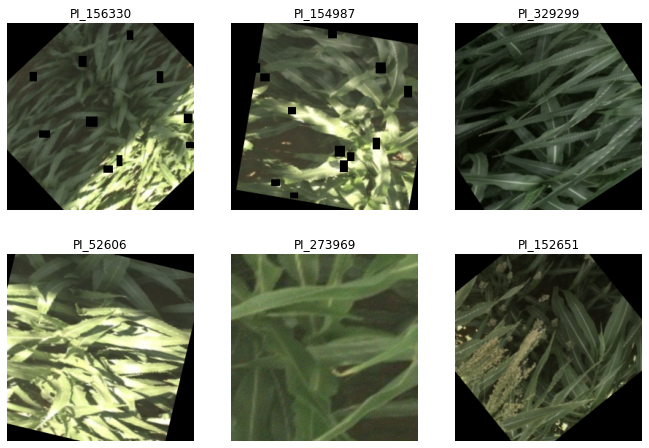

In [9]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(9, 6))
for i in range(6):
    ax = plt.subplot(2, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype(np.uint8))
    label = label_batch[i].numpy()
    plt.title(class_names[label])
    plt.axis("off")

In [10]:
# Build Model

model = get_model(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), output_shape=num_classes)

In [11]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 efficientnetv2-b0 (Function  (None, 8, 8, 1280)       5919312   
 al)                                                             
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 100)               128100    
                                                                 
Total params: 6,047,412
Trainable params: 5,986,804
Non-train

In [12]:
train_classes, train_counts = np.unique(train_target, return_counts=True)

weight = (1/train_counts) * (len(train_target)/num_classes)
class_weight = {i:weight[i] for i in range(len(weight))}

In [13]:
steps_per_epoch = len(train_target)//BATCH_SIZE
validation_steps = len(valid_target)//BATCH_SIZE

In [14]:
model.compile(optimizer=tfa.optimizers.RectifiedAdam(learning_rate=MAX_LR,
                                                     total_steps=EPOCHS*steps_per_epoch,
                                                     warmup_proportion=0.2,
                                                     min_lr=MIN_LR), 
              loss=tf.losses.SparseCategoricalCrossentropy(), 
              metrics=['accuracy'])

In [15]:
my_callbacks = tf.keras.callbacks.EarlyStopping(patience=PATIENCE, 
                                                monitor='val_loss', 
                                                restore_best_weights=True)

In [16]:
history = model.fit(train_ds, 
                    validation_data=valid_ds,
                    epochs=EPOCHS,
                    callbacks=[my_callbacks],
                    class_weight=class_weight,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps)

Epoch 1/80
2080/2080 [==============================] - 841s 387ms/step - loss: 4.6557 - accuracy: 0.0128 - val_loss: 4.5436 - val_accuracy: 0.0236
Epoch 2/80
2080/2080 [==============================] - 820s 392ms/step - loss: 4.2262 - accuracy: 0.0549 - val_loss: 3.3559 - val_accuracy: 0.1726
Epoch 3/80
2080/2080 [==============================] - 817s 393ms/step - loss: 3.4572 - accuracy: 0.1615 - val_loss: 2.4310 - val_accuracy: 0.3503
Epoch 4/80
2080/2080 [==============================] - 792s 381ms/step - loss: 2.9258 - accuracy: 0.2527 - val_loss: 2.0029 - val_accuracy: 0.4452
Epoch 5/80
2080/2080 [==============================] - 796s 383ms/step - loss: 2.5863 - accuracy: 0.3199 - val_loss: 1.7998 - val_accuracy: 0.4894
Epoch 6/80
2080/2080 [==============================] - 792s 381ms/step - loss: 2.3636 - accuracy: 0.3713 - val_loss: 1.5330 - val_accuracy: 0.5709
Epoch 7/80
2080/2080 [==============================] - 793s 381ms/step - loss: 2.2204 - accuracy: 0.4088 - val_

In [17]:
model.save(f'./output/model_E_R_C.h5')

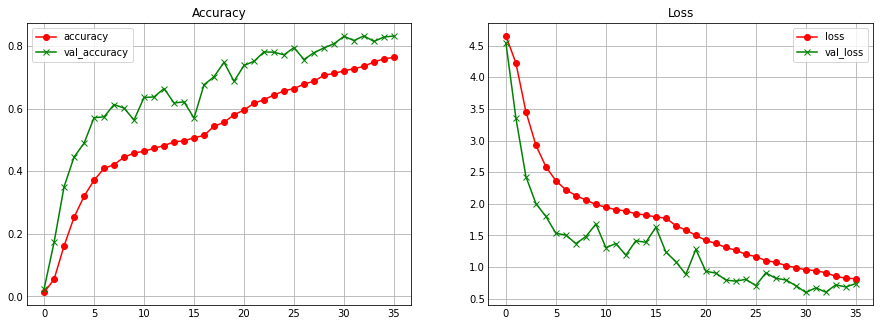

In [18]:
# Validate the Model

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.set_title('Accuracy')
ax1.plot(history.history['accuracy'], 'r', marker="o", label='accuracy')
ax1.plot(history.history['val_accuracy'], 'g', marker="x", label='val_accuracy')
ax1.legend()

ax2.set_title('Loss')
ax2.plot(history.history['loss'], 'r', marker="o", label='loss')
ax2.plot(history.history['val_loss'], 'g', marker="x", label='val_loss')
ax2.legend()

plt.show()

In [19]:
val_preds = model.predict(valid_ds, steps=validation_steps)
val_preds = np.argmax(val_preds, axis=1)

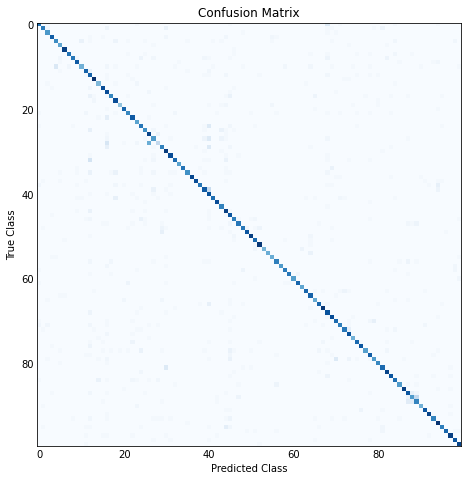

In [20]:
matrix = tf.math.confusion_matrix(valid_target[:validation_steps * BATCH_SIZE], val_preds).numpy()

plt.figure(figsize=(6, 6))
plt.imshow(matrix)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.grid(False)
plt.show()

## Submit the Result

In [21]:
def process_data_test(path):
    img = tf.io.read_file(path)
    img = tf.io.decode_png(img, channels=3)
    img = tf.image.resize(img, size=[IMG_HEIGHT, IMG_WIDTH])
    return img

In [22]:
df = pd.read_csv('./input/sample_submission.csv')

In [23]:
path = './input/test/'
test_images = np.array([path+i for i in df['filename']])

test_ds = tf.data.Dataset.from_tensor_slices(test_images)
test_ds = test_ds.map(process_data_test, num_parallel_calls=tf.data.AUTOTUNE)

In [24]:
test_ds = test_ds.batch(BATCH_SIZE)
preds = model.predict(test_ds)
preds = np.argmax(preds, axis=1)
preds = [class_names[i] for i in preds]

In [25]:
df['cultivar'] = preds
df.to_csv(f'./output/E_R_C.csv', index=False)